# Gaussian Random Walk Time-Varying Regression Coefficients in PyMC

## Prepare Notebook

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import pymc as pm
import pymc.sampling_jax
from sklearn.preprocessing import StandardScaler
import seaborn as sns


plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "png"

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.8/site-packages/aesara/link/jax/dispatch.py:87: UserWarning: JAX omnistaging couldn't be disabled: Disabling of omnistaging is no longer supported in JAX version 0.2.12 and higher: see https://github.com/google/jax/blob/main/design_notes/omnistaging.md.
  warnings.warn(f"JAX omnistaging couldn't be disabled: {e}")
/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.8/site-packages/pymc/sampling_jax.py:36: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


## Read Data

In [2]:
data_path = "https://raw.githubusercontent.com/christophM/interpretable-ml-book/master/data/bike.csv"

raw_data_df = pd.read_csv(data_path)

raw_data_df.head()


,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,days_since_2011
0,WINTER,2011,JAN,NO HOLIDAY,SAT,NO WORKING DAY,MISTY,8.175849,80.5833,10.749882,985,0
1,WINTER,2011,JAN,NO HOLIDAY,SUN,NO WORKING DAY,MISTY,9.083466,69.6087,16.652113,801,1
2,WINTER,2011,JAN,NO HOLIDAY,MON,WORKING DAY,GOOD,1.229108,43.7273,16.636703,1349,2
3,WINTER,2011,JAN,NO HOLIDAY,TUE,WORKING DAY,GOOD,1.400000,59.0435,10.739832,1562,3
4,WINTER,2011,JAN,NO HOLIDAY,WED,WORKING DAY,GOOD,2.666979,43.6957,12.522300,1600,4


## Data Formatting

In [3]:
data_df = raw_data_df.copy().assign(
    date=pd.date_range(
        start=pd.to_datetime("2011-01-01"), end=pd.to_datetime("2012-12-31"), freq="D"
    )
)

data_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   season           731 non-null    object        
 1   yr               731 non-null    int64         
 2   mnth             731 non-null    object        
 3   holiday          731 non-null    object        
 4   weekday          731 non-null    object        
 5   workingday       731 non-null    object        
 6   weathersit       731 non-null    object        
 7   temp             731 non-null    float64       
 8   hum              731 non-null    float64       
 9   windspeed        731 non-null    float64       
 10  cnt              731 non-null    int64         
 11  days_since_2011  731 non-null    int64         
 12  date             731 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(3), object(6)
memory usage: 74.4+ KB


In [4]:
target = "cnt"
endog_scaler = StandardScaler()
exog_scaler = StandardScaler()


data_df[f"{target}_scaled"] = endog_scaler.fit_transform(X=data_df[[target]])
data_df[["temp_scaled", "hum_scaled", "windspeed_scaled"]] = exog_scaler.fit_transform(
    X=data_df[["temp", "hum", "windspeed"]]
)


In [5]:
n = data_df.shape[0]

date = data_df["date"].to_numpy()

cnt_scaled = data_df[f"{target}_scaled"].to_numpy()

temp_scaled = data_df["temp_scaled"].to_numpy()
hum_scaled = data_df["hum_scaled"].to_numpy()
windspeed_scaled = data_df["windspeed_scaled"].to_numpy()
holiday_idx, holiday = data_df["holiday"].factorize(sort=True)
workingday_idx, workingday = data_df["workingday"].factorize(sort=True)
weathersit_idx, weathersit = data_df["weathersit"].factorize(sort=True)
t = data_df["days_since_2011"].to_numpy() / data_df["days_since_2011"].max()

n_order = 10
periods = data_df["date"].dt.dayofyear / 365.25
fourier_features = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
)


## Base Model

In [6]:
coords = {
    "date": date,
    "workingday": workingday,
    "weathersit": weathersit,
}


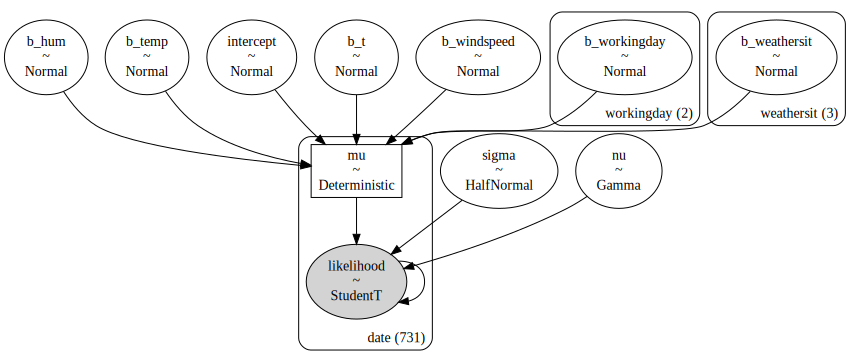

In [7]:
with pm.Model(coords=coords) as base_model:

    # --- priors ---
    intercept = pm.Normal(name="intercept", mu=0, sigma=2)
    b_temp = pm.Normal(name="b_temp", mu=0, sigma=2)
    b_hum = pm.Normal(name="b_hum", mu=0, sigma=2)
    b_windspeed = pm.Normal(name="b_windspeed", mu=0, sigma=2)
    b_workingday = pm.Normal(name="b_workingday", mu=0, sigma=2, dims="workingday")
    b_weathersit = pm.Normal(name="b_weathersit", mu=0, sigma=2, dims="weathersit")
    b_t = pm.Normal(name="b_t", mu=0, sigma=3)
    nu = pm.Gamma(name="nu", alpha=8, beta=2)
    sigma = pm.HalfNormal(name="sigma", sigma=2)

    # --- model parametrization ---
    mu = pm.Deterministic(
        name="mu",
        var=(
            intercept
            + b_t * t
            + b_temp * temp_scaled
            + b_hum * hum_scaled
            + b_windspeed * windspeed_scaled
            + b_workingday[workingday_idx]
            + b_weathersit[weathersit_idx]
        ),
        dims="date",
    )

    # --- likelihood ---
    likelihood = pm.StudentT(
        name="likelihood", mu=mu, nu=nu, sigma=sigma, dims="date", observed=cnt_scaled
    )

    # --- prior samples ---
    prior_predictive_base = pm.sample_prior_predictive(samples=200)

pm.model_to_graphviz(base_model)


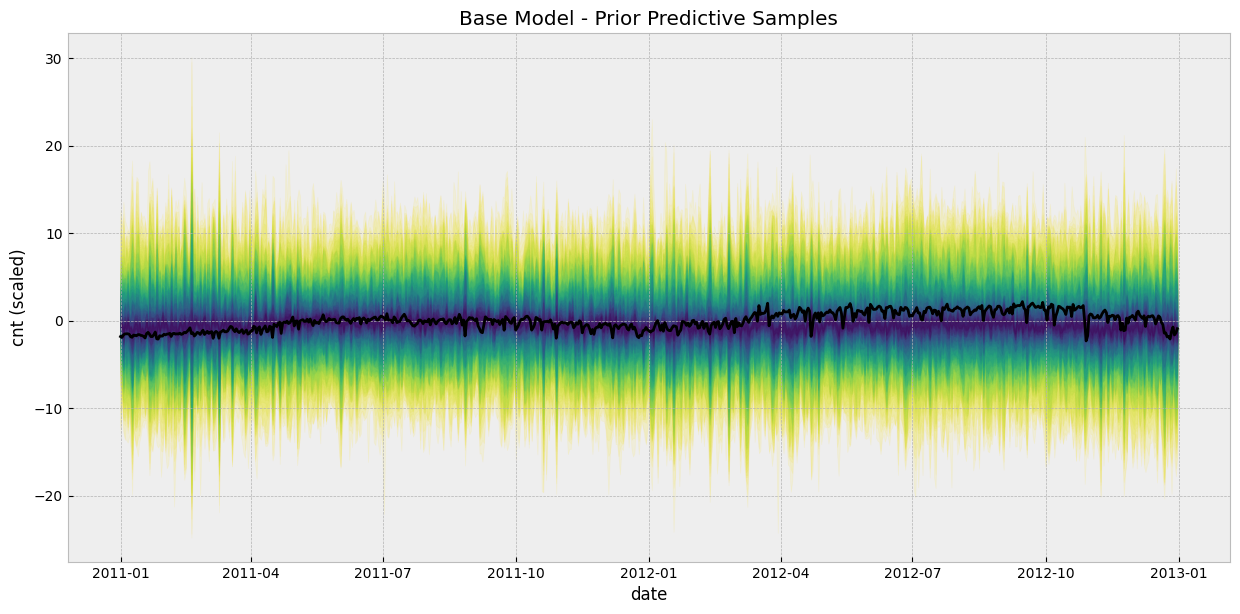

In [8]:
palette = "viridis_r"
cmap = plt.get_cmap(palette)
percs = np.linspace(51, 99, 100)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))


fig, ax = plt.subplots(figsize=(15, 7))

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(
        prior_predictive_base.prior_predictive["likelihood"], p, axis=1
    )
    lower = np.percentile(
        prior_predictive_base.prior_predictive["likelihood"], 100 - p, axis=1
    )
    color_val = colors[i]
    ax.fill_between(
        x=date,
        y1=upper.flatten(),
        y2=lower.flatten(),
        color=cmap(color_val),
        alpha=0.1,
    )
sns.lineplot(x=date, y=cnt_scaled, color="black", ax=ax)
ax.set(
    title="Base Model - Prior Predictive Samples",
    xlabel="date",
    ylabel=f"{target} (scaled)",
);


In [9]:
with base_model:
    idata_base = pm.sampling_jax.sample_numpyro_nuts(
        target_accept=0.8, draws=1000, chains=4
    )
    posterior_predictive_base = pm.sample_posterior_predictive(trace=idata_base)


Compiling...
Compilation time =  0:00:07.335893
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:28.596115
Transforming variables...
Transformation time =  0:00:00.230318


2022-06-24 18:27:08.909672: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:61] Constant folding an instruction is taking > 1s:

  %reduce.7 = f64[4,1000,731]{2,1,0} reduce(f64[4,1000,731,1]{3,2,1,0} %broadcast.12, f64[] %constant.10), dimensions={3}, to_apply=%region_1.255, metadata={op_name="jit(jax_funcified_fgraph)/jit(main)/reduce_prod[axes=(3,)]" source_file="/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.8/site-packages/aesara/link/jax/dispatch.py" source_line=173}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime.  XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.


In [10]:
az.summary(data=idata_base, var_names=["~mu"])


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,-0.655,1.331,-3.099,1.805,0.030,0.021,1990.0,2421.0,1.0
b_temp,0.512,0.017,0.482,0.545,0.000,0.000,3675.0,2459.0,1.0
b_hum,-0.114,0.021,-0.156,-0.077,0.000,0.000,4177.0,3054.0,1.0
b_windspeed,-0.100,0.017,-0.133,-0.069,0.000,0.000,4301.0,2857.0,1.0
b_workingday[NO WORKING DAY],-0.387,1.177,-2.499,1.875,0.027,0.020,1861.0,2253.0,1.0
b_workingday[WORKING DAY],-0.321,1.177,-2.416,1.959,0.027,0.020,1862.0,2245.0,1.0
b_weathersit[GOOD],0.128,1.033,-1.789,2.040,0.026,0.018,1623.0,1905.0,1.0
b_weathersit[MISTY],-0.051,1.032,-1.976,1.853,0.026,0.018,1626.0,1910.0,1.0
b_weathersit[RAIN/SNOW/STORM],-0.810,1.032,-2.707,1.147,0.026,0.018,1632.0,1893.0,1.0
b_t,1.990,0.058,1.882,2.097,0.001,0.001,3431.0,2413.0,1.0


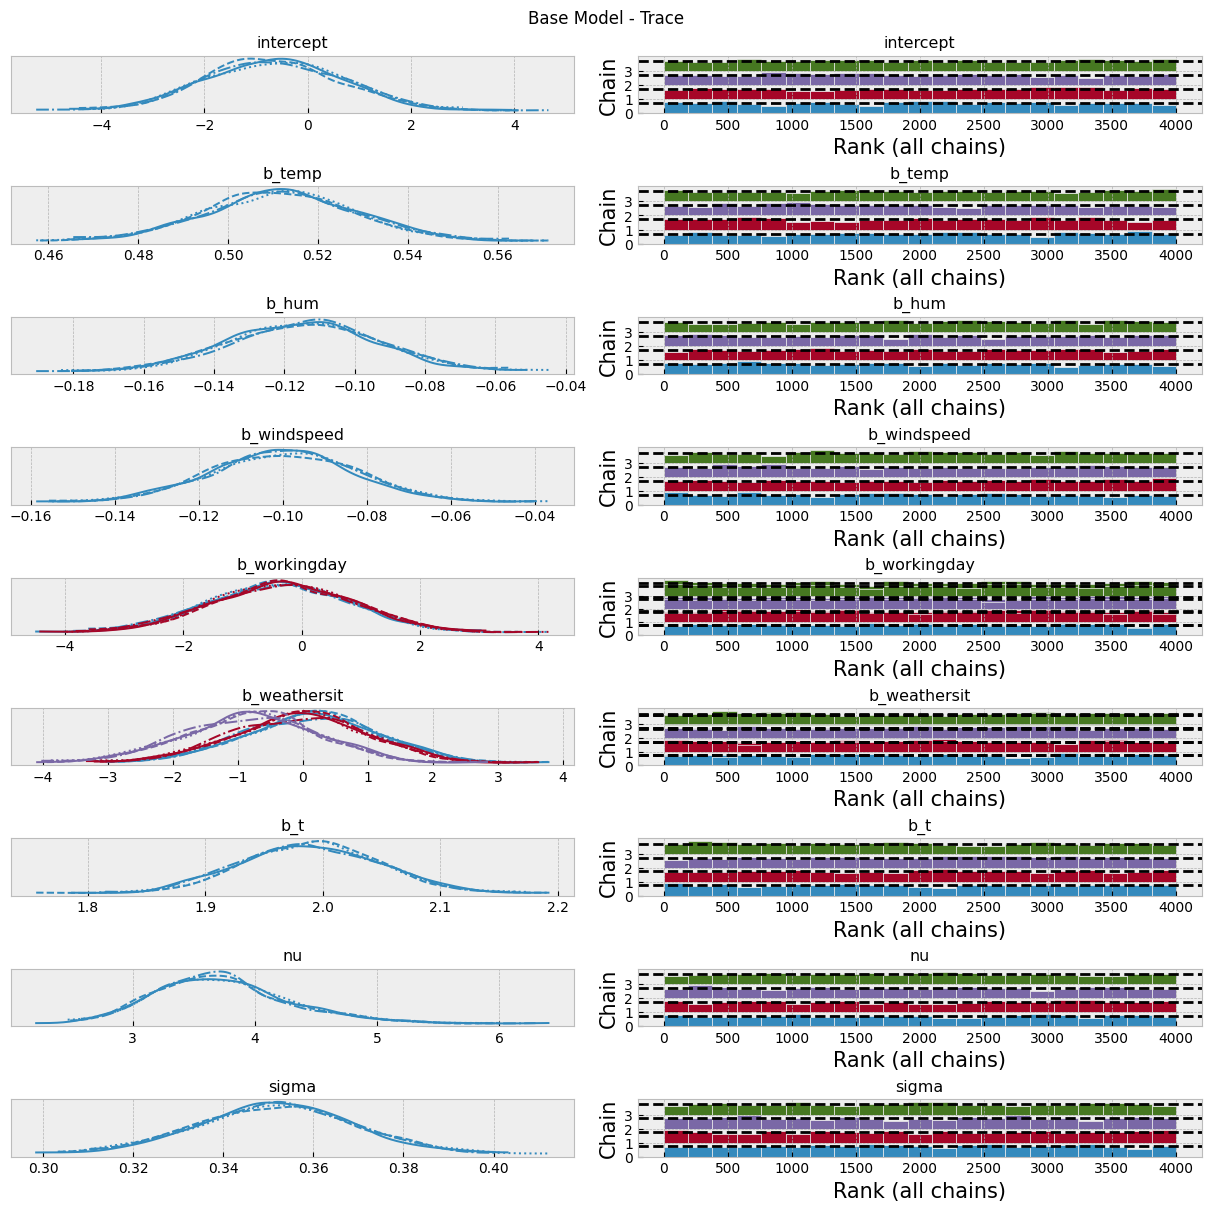

In [11]:
axes = az.plot_trace(
    data=idata_base,
    var_names=["~mu"],
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 12), "layout": "constrained"},
)
plt.gcf().suptitle("Base Model - Trace");


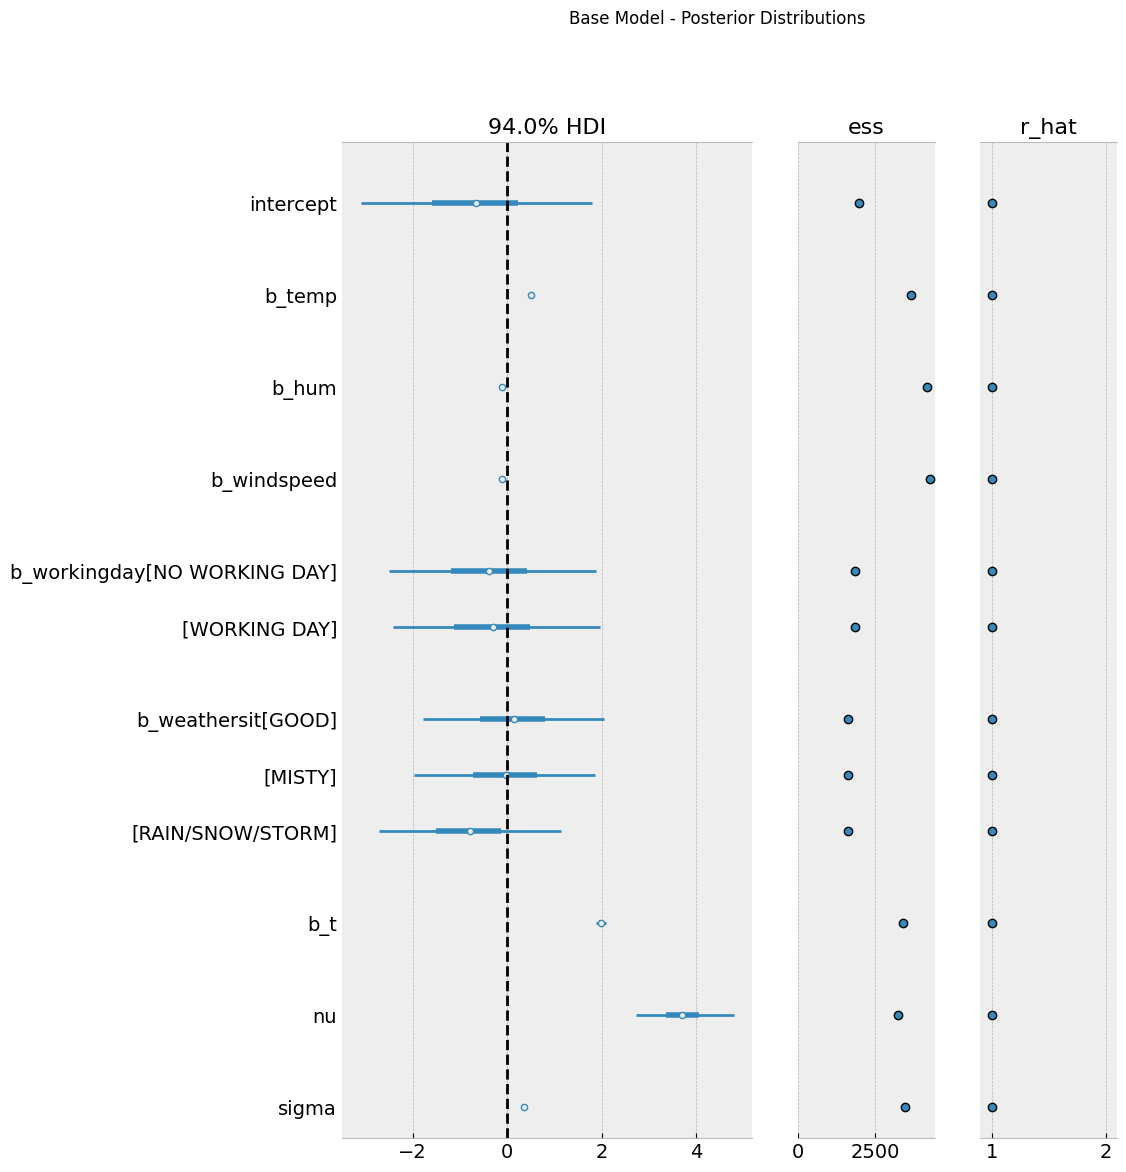

In [12]:
axes = az.plot_forest(
    data=idata_base,
    var_names=["~mu"],
    combined=True,
    r_hat=True,
    ess=True,
)
axes[0].axvline(x=0.0, color="black", linestyle="--")
plt.gcf().suptitle("Base Model - Posterior Distributions");


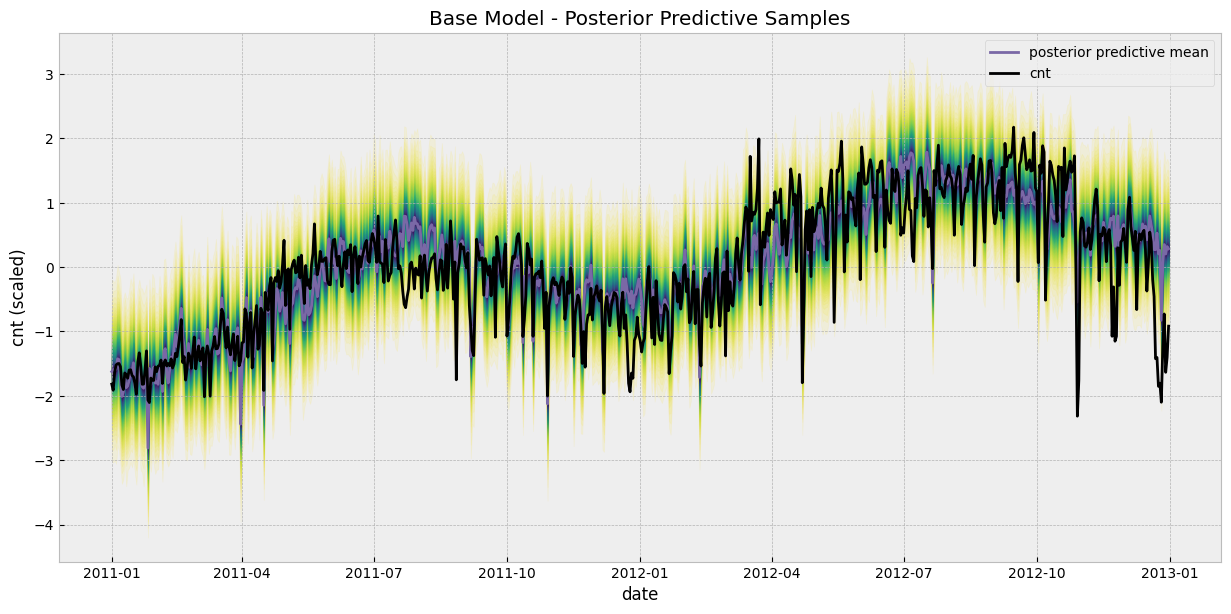

In [13]:
palette = "viridis_r"
cmap = plt.get_cmap(palette)
percs = np.linspace(51, 99, 100)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))


posterior_predictive_likelihood = posterior_predictive_base.posterior_predictive[
    "likelihood"
].stack(sample=("chain", "draw"))

fig, ax = plt.subplots(figsize=(15, 7))

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(posterior_predictive_likelihood, p, axis=1)
    lower = np.percentile(posterior_predictive_likelihood, 100 - p, axis=1)
    color_val = colors[i]
    ax.fill_between(
        x=date,
        y1=upper,
        y2=lower,
        color=cmap(color_val),
        alpha=0.1,
    )

sns.lineplot(
    x=date,
    y=posterior_predictive_likelihood.mean(axis=1),
    color="C2",
    label="posterior predictive mean",
    ax=ax,
)
sns.lineplot(
    x=date,
    y=cnt_scaled,
    color="black",
    label=target,
    ax=ax,
)

ax.set(
    title="Base Model - Posterior Predictive Samples",
    xlabel="date",
    ylabel=f"{target} (scaled)",
);


## Time-Varying Coefficients Model

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.8/site-packages/pymc/distributions/timeseries.py:274: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(


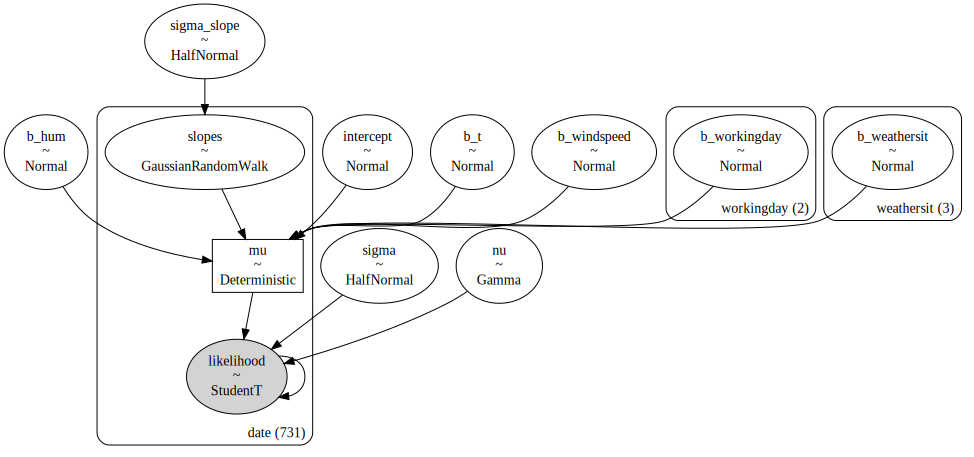

In [80]:
with pm.Model(coords=coords) as model:

    # --- priors ---
    intercept = pm.Normal(name="intercept", mu=0, sigma=2)
    b_hum = pm.Normal(name="b_hum", mu=0, sigma=2)
    b_windspeed = pm.Normal(name="b_windspeed", mu=0, sigma=2)
    b_workingday = pm.Normal(name="b_workingday", mu=0, sigma=2, dims="workingday")
    b_weathersit = pm.Normal(name="b_weathersit", mu=0, sigma=2, dims="weathersit")
    b_t = pm.Normal(name="b_t", mu=0, sigma=3)
    sigma_slopes = pm.HalfNormal(name="sigma_slope", sigma=1)
    nu = pm.Gamma(name="nu", alpha=8, beta=2)
    sigma = pm.HalfNormal(name="sigma", sigma=2)

    # --- model parametrization ---
    slopes = pm.GaussianRandomWalk(name="slopes", sigma=sigma_slopes, dims="date")
    mu = pm.Deterministic(
        name="mu",
        var=(
            intercept
            + b_t * t
            + slopes * temp_scaled
            + b_hum * hum_scaled
            + b_windspeed * windspeed_scaled
            + b_workingday[workingday_idx]
            + b_weathersit[weathersit_idx]
        ),
        dims="date",
    )

    # --- likelihood ---
    likelihood = pm.StudentT(
        name="likelihood", mu=mu, nu=nu, sigma=sigma, dims="date", observed=cnt_scaled
    )

    # --- prior samples ---
    prior_predictive = pm.sample_prior_predictive(samples=200)

pm.model_to_graphviz(model)

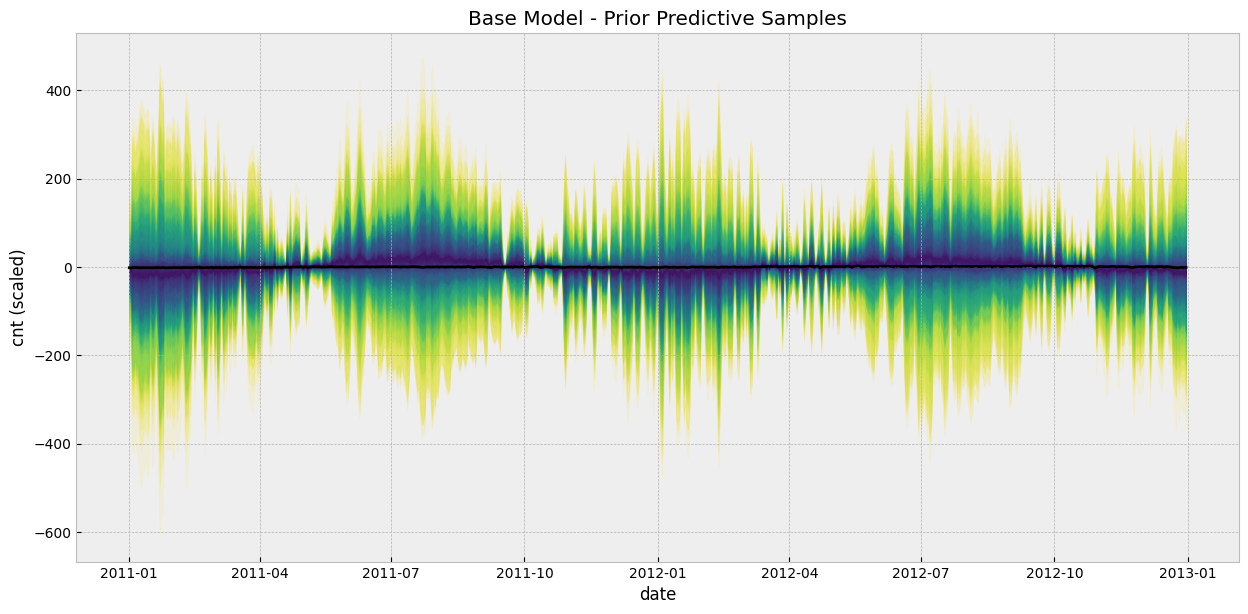

In [81]:
palette = "viridis_r"
cmap = plt.get_cmap(palette)
percs = np.linspace(51, 99, 100)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))


fig, ax = plt.subplots(figsize=(15, 7))

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(
        prior_predictive.prior_predictive["likelihood"], p, axis=1
    )
    lower = np.percentile(
        prior_predictive.prior_predictive["likelihood"], 100 - p, axis=1
    )
    color_val = colors[i]
    ax.fill_between(
        x=date,
        y1=upper.flatten(),
        y2=lower.flatten(),
        color=cmap(color_val),
        alpha=0.1,
    )
sns.lineplot(x=date, y=cnt_scaled, color="black", ax=ax)
ax.set(
    title="Base Model - Prior Predictive Samples",
    xlabel="date",
    ylabel=f"{target} (scaled)",
);


In [29]:
with model:
    idata = pm.sampling_jax.sample_numpyro_nuts(
        target_accept=0.8, draws=1000, chains=4
    )
    posterior_predictive = pm.sample_posterior_predictive(trace=idata)


Compiling...
Compilation time =  0:00:03.355777
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:01:18.235984
Transforming variables...
Transformation time =  0:00:00.342392


2022-06-24 18:36:32.500241: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:61] Constant folding an instruction is taking > 8s:

  %reduce.7 = f64[4,1000,731]{2,1,0} reduce(f64[4,1000,731,1]{3,2,1,0} %broadcast.12, f64[] %constant.10), dimensions={3}, to_apply=%region_1.254, metadata={op_name="jit(jax_funcified_fgraph)/jit(main)/reduce_prod[axes=(3,)]" source_file="/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.8/site-packages/aesara/link/jax/dispatch.py" source_line=173}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime.  XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.


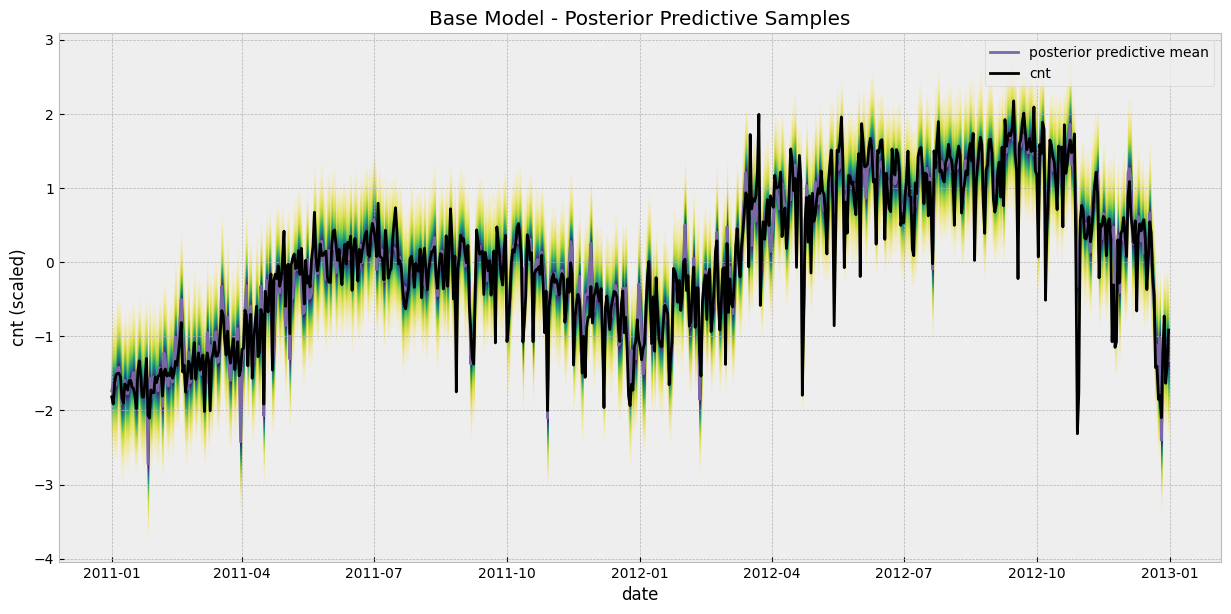

In [33]:
palette = "viridis_r"
cmap = plt.get_cmap(palette)
percs = np.linspace(51, 99, 100)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))


posterior_predictive_likelihood = posterior_predictive.posterior_predictive[
    "likelihood"
].stack(sample=("chain", "draw"))

fig, ax = plt.subplots(figsize=(15, 7))

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(posterior_predictive_likelihood, p, axis=1)
    lower = np.percentile(posterior_predictive_likelihood, 100 - p, axis=1)
    color_val = colors[i]
    ax.fill_between(
        x=date,
        y1=upper,
        y2=lower,
        color=cmap(color_val),
        alpha=0.1,
    )

sns.lineplot(
    x=date,
    y=posterior_predictive_likelihood.mean(axis=1),
    color="C2",
    label="posterior predictive mean",
    ax=ax,
)
sns.lineplot(
    x=date,
    y=cnt_scaled,
    color="black",
    label=target,
    ax=ax,
)

ax.set(
    title="Base Model - Posterior Predictive Samples",
    xlabel="date",
    ylabel=f"{target} (scaled)",
);


In [61]:
data_df.assign(
        b_temp=idata_base.posterior["b_temp"].stack(sample=("chain", "draw")).mean().to_numpy(),
    )

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,days_since_2011,date,cnt_scaled,temp_scaled,hum_scaled,windspeed_scaled,b_temp
0,WINTER,2011,JAN,NO HOLIDAY,SAT,NO WORKING DAY,MISTY,8.175849,80.5833,10.749882,985,0,2011-01-01,-1.817953,-0.826662,1.250171,-0.387892,0.511903
1,WINTER,2011,JAN,NO HOLIDAY,SUN,NO WORKING DAY,MISTY,9.083466,69.6087,16.652113,801,1,2011-01-02,-1.912999,-0.721095,0.479113,0.749602,0.511903
2,WINTER,2011,JAN,NO HOLIDAY,MON,WORKING DAY,GOOD,1.229108,43.7273,16.636703,1349,2,2011-01-03,-1.629925,-1.634657,-1.339274,0.746632,0.511903
3,WINTER,2011,JAN,NO HOLIDAY,TUE,WORKING DAY,GOOD,1.400000,59.0435,10.739832,1562,3,2011-01-04,-1.519898,-1.614780,-0.263182,-0.389829,0.511903
4,WINTER,2011,JAN,NO HOLIDAY,WED,WORKING DAY,GOOD,2.666979,43.6957,12.522300,1600,4,2011-01-05,-1.500269,-1.467414,-1.341494,-0.046307,0.511903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,WINTER,2012,DEC,NO HOLIDAY,THU,WORKING DAY,MISTY,3.945849,65.2917,23.458911,2114,726,2012-12-27,-1.234757,-1.318665,0.175807,2.061426,0.511903
727,WINTER,2012,DEC,NO HOLIDAY,FRI,WORKING DAY,MISTY,3.906651,59.0000,10.416557,3095,727,2012-12-28,-0.728012,-1.323224,-0.266238,-0.452131,0.511903
728,WINTER,2012,DEC,NO HOLIDAY,SAT,NO WORKING DAY,MISTY,3.906651,75.2917,8.333661,1341,728,2012-12-29,-1.634057,-1.323224,0.878392,-0.853552,0.511903
729,WINTER,2012,DEC,NO HOLIDAY,SUN,NO WORKING DAY,GOOD,4.024151,48.3333,23.500518,1796,729,2012-12-30,-1.399023,-1.309558,-1.015664,2.069444,0.511903


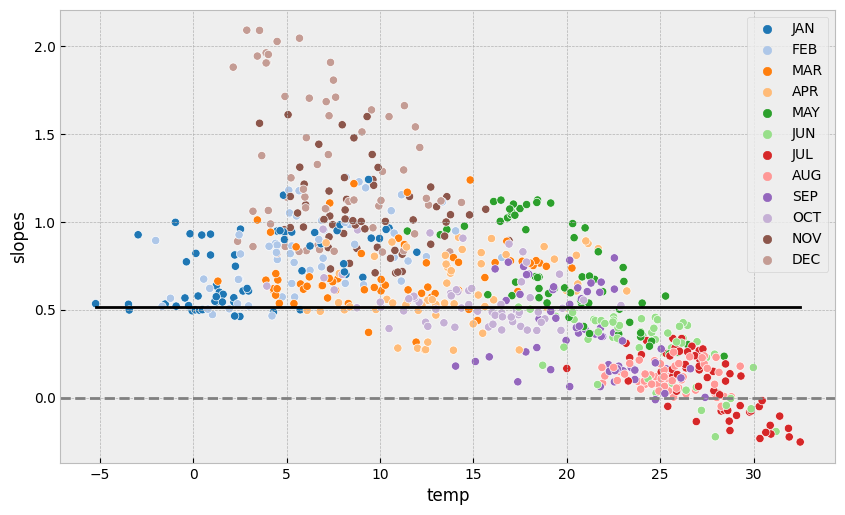

In [64]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(
    x="temp",
    y="slopes",
    hue="mnth",
    palette="tab20",
    data=data_df.assign(
        slopes=idata.posterior["slopes"].stack(sample=("chain", "draw")).mean(axis=1)
    ),
)
sns.lineplot(
    x="temp",
    y="b_temp",
    color="black",
    data=data_df.assign(
        b_temp=idata_base.posterior["b_temp"]
        .stack(sample=("chain", "draw"))
        .mean()
        .to_numpy()
    ),
)
ax.axhline(y=0.0, color="gray", linestyle="--")


<AxesSubplot:xlabel='date', ylabel='temp'>

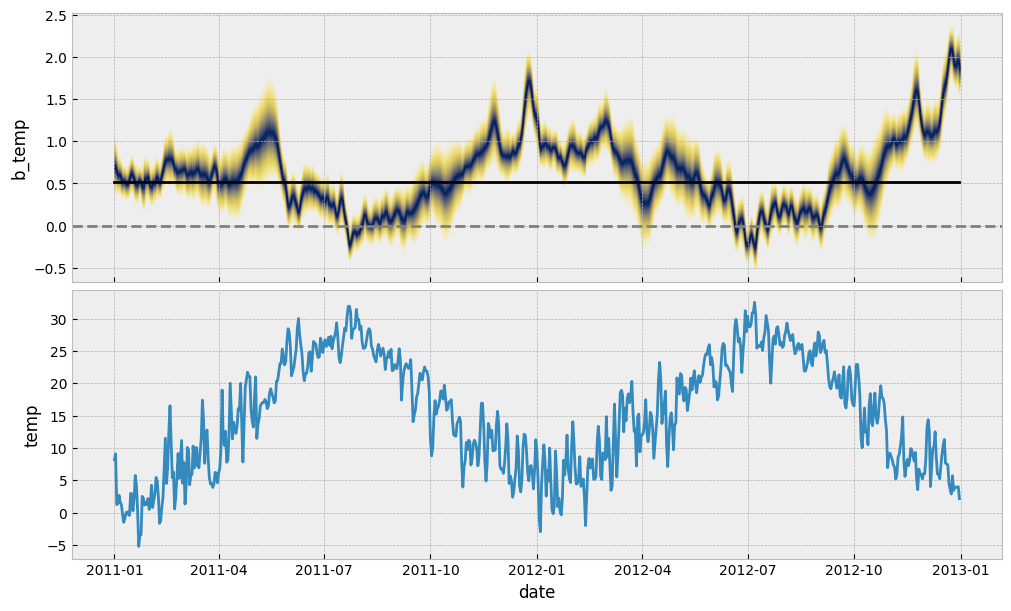

In [77]:
palette = "cividis_r"
cmap = plt.get_cmap(palette)
percs = np.linspace(51, 99, 100)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))


posterior_predictive_slopes = idata.posterior["slopes"].stack(sample=("chain", "draw"))

fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(10, 6), sharex=True, sharey=False, layout="constrained"
)

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(posterior_predictive_slopes, p, axis=1)
    lower = np.percentile(posterior_predictive_slopes, 100 - p, axis=1)
    color_val = colors[i]
    ax[0].fill_between(
        x=date,
        y1=upper,
        y2=lower,
        color=cmap(color_val),
        alpha=0.1,
    )

sns.lineplot(
    x="date",
    y="b_temp",
    color="black",
    data=data_df.assign(
        b_temp=idata_base.posterior["b_temp"]
        .stack(sample=("chain", "draw"))
        .mean()
        .to_numpy()
    ),
    ax=ax[0]
)
ax[0].axhline(y=0.0, color="gray", linestyle="--")

sns.lineplot(x="date", y="temp", color="C0", data=data_df, ax=ax[1])